# Reinforcement learning activity

In this activity, you will make an agent that uses reinforcement learning to navigate the Cliff Walking environment. You will write methods in the agent class to implement Q-learning and an $\epsilon$-greedy action selection strategy. 

There are 3 main tasks for you to complete and 2 tasks to plot the results of the RL model. Cells have clearly marked `# TODO` and `#####` comments for you to insert your code between. Variables assigned to `None` should keep the same name but assigned to their proper implementation.

1. Complete the `get_action` method of the agent and implement an $\epsilon$-greedy strategy
2. Complete the `update` method of the agent and implement the temporal difference loss and update equation for Q-learning
3. Complete the training loop for the RL model
4. Plot the training metrics
5. Plot the path and policy at various points of training

In [3]:
# TODO: Run this in Google Colab to install the RL gym package
# !pip install gymnasium

In [4]:
# TODO: Run this cell to import relevant packages

import numpy as np  # Arrays and numerical computing
from tqdm import tqdm  # Progress bar
import gymnasium as gym  # Reinforcement learning environments
import random  # Random number generation

import matplotlib.pyplot as plt  # Plotting and visualization
from matplotlib import patches
from matplotlib import colormaps
cmap = colormaps.get_cmap("jet")

# Cliff Walking environment
[Gymnasium documentation for cliff walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/#arguments)

## Observation and state space
The goal of the cliff walking environment is to cross a $4 \times 12$ grid from the start point to the end point while avoiding falling off a cliff, which covers 10 tiles at the bottom of the grid. An observation is a representation of the current environment (e.g. position), while a state is a valid representation for the agent to be in. Note that not all observations are states (e.g. the agent cannot be on a cliff space), but all states are observations.

The observation space contains 48 discrete locations at each point in the grid, although only 38 of them are valid states for the agent to be in: the 36 upper green tiles (states 0..35), the blue start space (state 36), and the red end space (state 47). Brown tiles (observations 37..46) represent the cliff and are not valid states for the agent. If the agent moves into a cliff tile, it returns to the start space. The agent starts in state 36 and the goal is to traverse the environment to state 47.

## Action space
The action space describes all possible actions the agent can take to interact with its environment. The action space for cliff walking contains 4 discrete actions, corresponding to the 4 directions the agent can move:
  - 0: Move up ($\uarr$)
  - 1: Move right ($\rarr$)
  - 2: Move down ($\darr$)
  - 3: Move left ($\larr$)

## Reward
The agent is rewarded -1 for every timestep spent in the environment. If the agent steps off the cliff, it incurrs a -100 reward. As we are trying to maximize the reward upon completion of the task, the agent should try to learn how to reach the end tile in a minimum number of time steps, thus taking the shortest path. As there is a steep penalty for falling off the cliff, the agent should learn not to do this too.

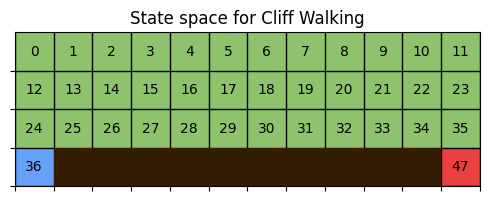

In [5]:
# TODO: Run this cell to visualize the state space
fig, ax = plt.subplots(figsize=(6, 2))

xs = np.arange(12)
ys = np.arange(4)
xs, ys = np.meshgrid(xs, ys, indexing="xy")

labels = np.arange(48)

for x, y, label in zip(xs.flatten(), ys.flatten(), labels):
    ax.text(x + 0.5, -y + 3.5, label, c='k', ha="center", va="center")

ax.set_xticks(np.arange(0, 13))
ax.set_yticks(np.arange(0, 4))
ax.set_xlim(0, 12)
ax.set_ylim(0, 4)
ax.grid(lw=1, c='k')

# Add in color patches
grass = patches.Rectangle(xy=(0, 1), width=13, height=3, fc="xkcd:grass green", alpha=0.6, zorder=0)
start = patches.Rectangle(xy=(0, 0), width=1, height=1, fc="xkcd:bright blue", alpha=0.6, zorder=0)
end = patches.Rectangle(xy=(11, 0), width=1, height=1, fc="xkcd:red", alpha=0.75, zorder=0)
cliff = patches.Rectangle(xy=(1, 0), width=10, height=1, fc="xkcd:dark brown", zorder=3)
for patch in [grass, start, end, cliff]:
    ax.add_patch(patch)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("State space for Cliff Walking")
plt.show()

# 1 and 2: Complete the agent implementation

The main attribute of the `Agent` class we will interact with is the `self.q_values` array. The array is 48 x 4, and represents the possible actions ($a_t$) that could be taken in the given state ($s_t$). Recall the action-value function, $Q(s, a)$, represents the value of taking action $a$ in state $s$. We can get the value of $Q(s, a)$ by simply indexing `self.q_values[s, a]`. 

The temporal difference loss for Q-learning is as follows:

$$\mathcal{L_{td}} = r_t + \gamma \cdot \max_a Q(s_{t+1}, a) - Q(s_t, a_t)$$

where $\max_a Q(s_{t+1}, a)$ is the optimal future action value as computed by the maximal Q value for the next observation, $s_{t+1}$. 

The update rule for Q-learning is as follows, where $\eta$ is the learning rate:
$$Q^{\text{new}}(s, a) = Q^{\text{old}}(s, a) + \eta \cdot \mathcal{L_{td}}$$

$\epsilon$-greedy action selection chooses a random action ($a_t \in \{0, 1, 2, 3\}$) with probability $\epsilon$, and choose the optimal action ($a_t = \text{arg} \max_{a} Q(s_t, a)$) otherwise.

The RL gym environment deals with the logic of running the game, so you can assume that the `observation` values it passes to the agent are valid states.

In [6]:
env = gym.make("CliffWalking-v0")

In [7]:
class Agent:
    def __init__(self, learning_rate, epsilon, discount_factor=1):
        """
        Parameters:
        -----------
        learning_rate: float, learning rate used in Q-learning update step
        epsilon: float, between [0, 1), probability that the agent will take a random action
        discount_factor: float, by default 1, the importance of future rewards 
        """
        self.n_actions = env.action_space.n
        self.n_observations = env.observation_space.n
        self.q_values = np.zeros((self.n_observations, self.n_actions))  # 48 x 4
        self.lr = learning_rate
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.td_history = []
        self.q_history = {}

    def get_action(self, observation):
        """Epsilon-greedy action selection

        Parameters:
        -----------
        observation: int, observation of the agent's state from the environment

        Returns:
        --------
        action: int, selected action the agent will perform
        """
        # TODO: Implement epsilon greedy sampling action sampling
        if np.random.rand() < self.epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(self.q_values[observation, :]))
        #####
        return action
        
    def update(self, observation, action, reward, terminated, next_observation):
        """Updates the Q values after taking an action in the environment

        Parameters:
        -----------
        observation: int, obesrvation of the agent's state from the environment
        action: int, action the agent selected to perform
        reward: float, the reward of performing the action from the environment
        terminated: bool, whether the episode has been terminated by reaching the end or taking too long
        next_observation: int, the next observation the agent will receive after performing its action
        """
        # TODO: Compute the TD loss for Q-learing
        if terminated:
            future_q_value = 0
        else:
            future_q_value = np.max(self.q_values[next_observation, :])
        td_loss = reward + self.discount_factor * future_q_value - self.q_values[observation, action]
        # TODO: Write the update rule for Q(s, a)
        self.q_values[observation, action] += self.lr * td_loss
        #####
        self.td_history.append(td_loss)

## 3. Complete the training loop and run the RL algorithm
Fill in the parts of the training loop with the correct methods from the agent. Then, run the cell to complete the training.

In [9]:
# TODO: Instantiate an agent with learning rate 0.1 and 0.05 exploration rate
agent = Agent(0.1, 0.05)
#####

env = gym.make("CliffWalking-v0")
n_episodes = 30000
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
save_episodes = [0, 1, 5, 10, 50, 100, 200, 500, 1000, 10000]

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    path = [obs]
    while not done:
        # TODO: Retrieve an action from the agent
        action = agent.get_action(obs)
        #####
        next_obs, reward, terminated, truncated, info = env.step(action)  # Let environment process agent's action
        # TODO: Update the agent's policy with environment's feedback
        agent.update(obs, action, reward, terminated, next_obs)
        #####
        # Update bookkeeping variables
        done = terminated or truncated
        obs = next_obs
        path.append(obs)
    if episode in save_episodes:
        agent.q_history[episode] = (agent.q_values.copy(), path)

100%|██████████| 30000/30000 [00:43<00:00, 694.08it/s]


## 4. Plot the learning metrics

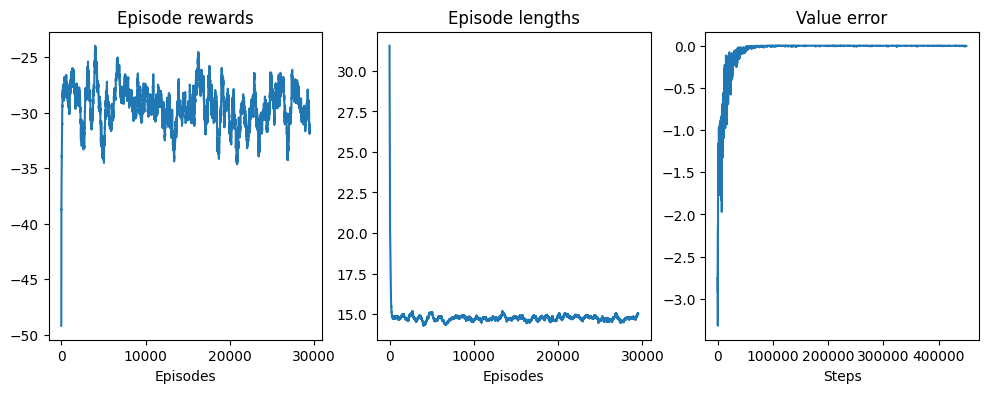

In [21]:
# TODO: Run this cell to plot the training metrics

def smooth(signal):
    averaging_window_length = 500
    return np.convolve(signal, np.ones(averaging_window_length)/averaging_window_length, mode='valid')

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.title('Episode rewards')
reward = smooth(np.array(env.return_queue).flatten())
plt.plot(range(len(reward)), reward)
plt.xlabel('Episodes')

plt.subplot(132)
plt.title('Episode lengths')
length = smooth(np.array(env.length_queue).flatten())
plt.plot(range(len(length)), length)
plt.xlabel('Episodes')

plt.subplot(133)
plt.title('Value error')
value_error = smooth(agent.td_history)
plt.plot(range(len(value_error)), value_error)
plt.xlabel('Steps')

plt.show()

## 5. Plot the agent's history

In [23]:
# TODO: Run this cell to define the plotting functions

def plot_agent_history(agent):
    n = len(agent.q_history)

    fig, axs = plt.subplots(n, 2, figsize=(12, 2*n))

    for i, (episode, (q_values, path)) in enumerate(agent.q_history.items()):
        for ax in axs[i, :]:
            setup_axis(ax)
        plot_path(axs[i, 0], path, episode)
        plot_policy(axs[i, 1], q_values, episode)

    plt.tight_layout()
    plt.show()


def setup_axis(ax):
    ax.set_xticks(np.arange(0, 13))
    ax.set_yticks(np.arange(0, 4))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 4)
    ax.grid(lw=1, c='k')
    # Add in color patches
    grass = patches.Rectangle(xy=(0, 1), width=13, height=3, fc="xkcd:grass green", alpha=0.6, zorder=0)
    start = patches.Rectangle(xy=(0, 0), width=1, height=1, fc="xkcd:bright blue", alpha=0.6, zorder=0)
    end = patches.Rectangle(xy=(11, 0), width=1, height=1, fc="xkcd:red", alpha=0.75, zorder=0)
    cliff = patches.Rectangle(xy=(1, 0), width=10, height=1, fc="xkcd:dark brown", zorder=2)
    for patch in [grass, start, end, cliff]:
        ax.add_patch(patch)
    ax.set_xticklabels([])
    ax.set_yticklabels([])


def plot_policy(ax, q_values, episode):
    actions = {
        0: "^",
        1: ">",
        2: "v",
        3: "<"
    }
    policy = q_values.argmax(axis=-1)
    xs = np.arange(12)
    ys = np.arange(4)
    xs, ys = np.meshgrid(xs, ys, indexing="xy")

    for x, y, action in zip(xs.flatten(), ys.flatten(), policy[:37]):
        ax.scatter(x + 0.5, -y + 3.5, marker=actions[action], c='k')
    ax.set_title(f"Optimal policy after episode {episode}")


def plot_path(ax, path, episode):
    path = np.array(path)
    xs = path % 12
    ys = path // 12

    dxs = np.diff(xs)
    dys = np.diff(ys)
    colours = np.linspace(0, 1, len(dxs))
    offsets = np.linspace(-0.2, 0.2, len(dxs))[::-1]
    for x, y, dx, dy, c, offset in zip(xs, ys, dxs, dys, colours, offsets):
        ax.arrow(
            x + 0.5 - offset, -y + 3.5 - offset, 0.9*dx, -0.9*dy,
            head_length=0.2, length_includes_head=True,
            width=0.1,
            fc=cmap(c), alpha=0.5,
            zorder=3
        )
    ax.set_title(f"Path during episode {episode}")

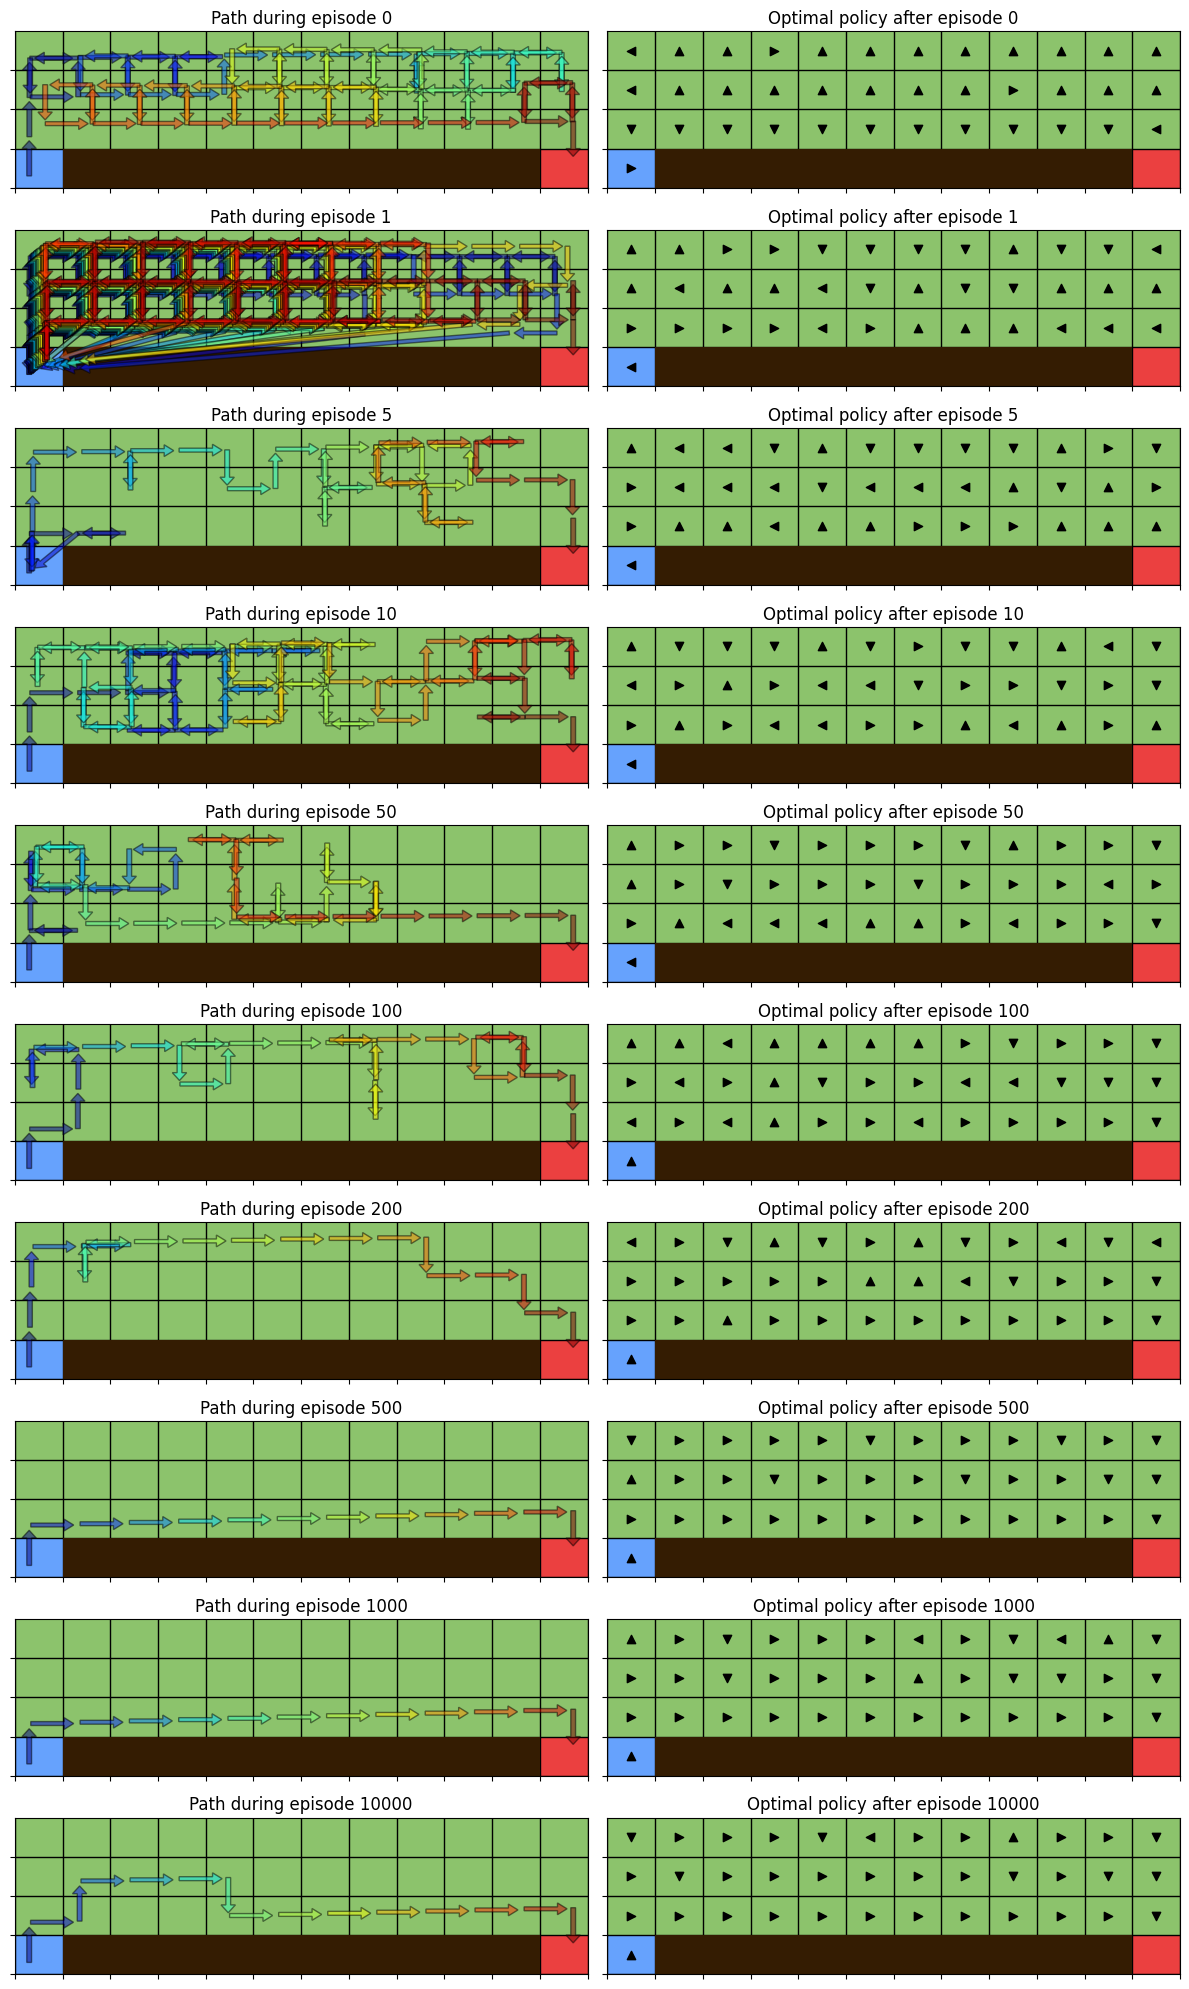

In [24]:
plot_agent_history(agent)